Forecasting Firm's Disaster Occurences Index develope notebook.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime
import geopandas as gpd
from scipy.spatial import cKDTree

# LSTM
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense 

import warnings 
warnings.filterwarnings("ignore") 

### LSTM

In [ ]:
filename = r'dataset\province_do.geojson'

In [6]:
# import data
df = gpd.read_file(filename)

wd = df[['ProvinceTH', 'wd_2018', 'wd_2019', 'wd_2020', 'wd_2021', 'wd_2022', 'wd_2023', 'wd_2024']].set_index('ProvinceTH').T
fl = df[['ProvinceTH', 'fl_2018', 'fl_2019', 'fl_2020', 'fl_2021', 'fl_2022', 'fl_2023', 'fl_2024']].set_index('ProvinceTH').T
pm = df[['ProvinceTH', 'pm_2018', 'pm_2019', 'pm_2020', 'pm_2021', 'pm_2022', 'pm_2023', 'pm_2024']].set_index('ProvinceTH').T

for d in [wd, fl, pm]:
    d.index = [datetime.strptime(ind.split('_')[-1], "%Y") for ind in d.index]

In [170]:
# Prepare the dataset for LSTM
def create_dataset(data: pd.DataFrame):
    data = data.T.values
    X = data[:, :-1]
    y = data[:, -1]
    return np.array(X), np.array(y)

In [41]:
class LSTM_forcast:
    """
    Deep learning LSTM model forecasting n_occurances.
    """
    def __init__(self, time_steps: int):
        self.time_steps = time_steps
        self.model = self._build_model()

    def _build_model(self):

        model = Sequential()

        model.add(LSTM(50, return_sequences=True, input_shape=(self.time_steps, 1)))
        model.add(LSTM(50, return_sequences=False))

        model.add(Dense(1, activation='relu'))

        model.compile(optimizer='adam', loss='mean_squared_error')

        return model
    
    def train(self, x_train, y_train, epochs=100, batch_size=1, validation_data=None):
        self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data, verbose=0)

    def evaluate(self, x_test, y_test, verbose=0):
        return self.model.evaluate(x_test, y_test, verbose)

    def predict(self, observe_df: pd.DataFrame, future_steps, ind):
        # Predicting the next 'future_steps' years

        prediction_input = observe_df.T.values[ind, :-1]
        predictions = []

        for _ in range(future_steps):
            pred = self.model.predict(prediction_input.reshape(1, -1, 1), verbose=0)
            pred = np.round(pred)
            predictions.append(pred)
            prediction_input = np.append(prediction_input[1:], pred)

        predictions = np.array(predictions).reshape(-1, 1)

        return predictions
    
    def visualize_forecast(self, observe_df: pd.DataFrame, future_steps: int, ind):
        
        predictions = self.predict(observe_df=observe_df, future_steps=future_steps, ind=ind)

        # Create a DataFrame for the forecast
        forecast_years = pd.date_range(start=observe_df.index[-1], periods=future_steps+1, freq='A')[1:]
        forecast_df = pd.DataFrame(data=predictions, index=forecast_years, columns=['Forecast'])

        # Plot the results
        forecast_df.plot(label='Forecast', color='red')
        observe_df[observe_df.columns[ind]].plot(figsize = (9, 3), label='Observed')

        plt.title('Disaster Occurances Forecasting')        
        plt.legend()
        plt.show()

In [172]:
time_steps = 1

# Create dataset for each disaster
wd_X, wd_y = create_dataset(wd)
fl_X, fl_y = create_dataset(fl)
pm_X, pm_y = create_dataset(pm)

# Reshape input to be [samples, time steps, features] which is required for LSTM
wd_X = wd_X.reshape(wd_X.shape[0], wd_X.shape[1], 1)
fl_X = fl_X.reshape(fl_X.shape[0], fl_X.shape[1], 1)
pm_X = pm_X.reshape(pm_X.shape[0], pm_X.shape[1], 1)

wd_lstm = LSTM_forcast(time_steps=time_steps)
fl_lstm = LSTM_forcast(time_steps=time_steps)
pm_lstm = LSTM_forcast(time_steps=time_steps)

wd_lstm.train(wd_X, wd_y, epochs=300, batch_size=1)
fl_lstm.train(fl_X, fl_y, epochs=300, batch_size=1)
pm_lstm.train(pm_X, pm_y, epochs=300, batch_size=1)

print(f'wd_mse: {wd_lstm.evaluate(wd_X, wd_y)}')
print(f'fl_mse: {fl_lstm.evaluate(fl_X, fl_y)}')
print(f'pm_mse: {pm_lstm.evaluate(pm_X, pm_y)}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1267  
wd_mse: 0.10415960103273392
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2316  
fl_mse: 0.2756749391555786
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2769  
pm_mse: 0.31168830394744873


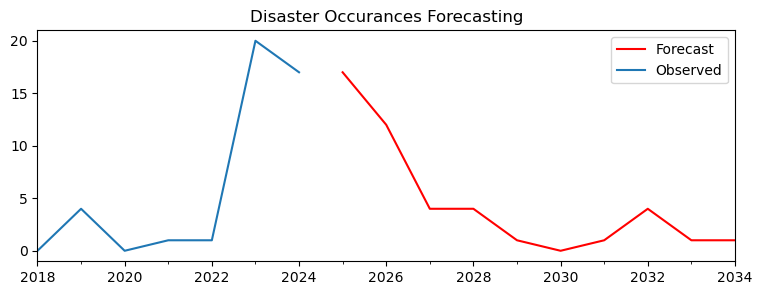

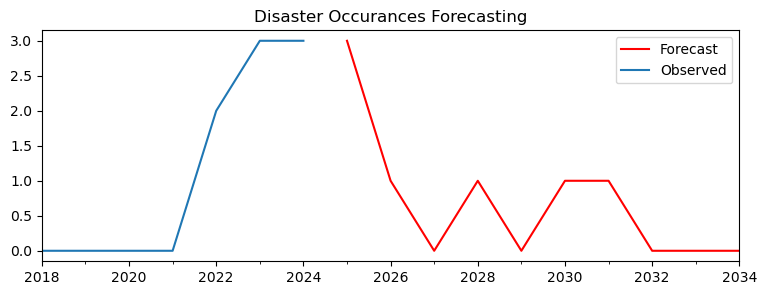

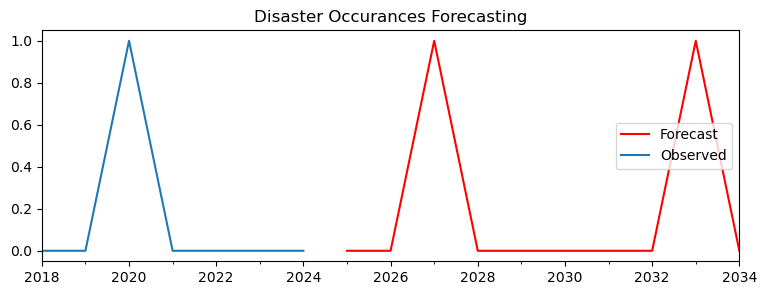

In [181]:
ind = np.random.randint(77)

wd_lstm.visualize_forecast(observe_df=wd, future_steps=10, ind=ind)
fl_lstm.visualize_forecast(observe_df=fl, future_steps=10, ind=ind)
pm_lstm.visualize_forecast(observe_df=pm, future_steps=10, ind=ind)

In [ ]:
wd_lstm.model.save('wd_forecast_model.keras')
fl_lstm.model.save('fl_forecast_model.keras')
pm_lstm.model.save('pm_forecast_model.keras')

### Test Production

In [6]:
#Load saved model
wd_test = keras.models.load_model(r'do_forecast_models\wd_forecast_model.keras')
fl_test = keras.models.load_model(r'do_forecast_models\fl_forecast_model.keras')
pm_test = keras.models.load_model(r'do_forecast_models\pm_forecast_model.keras')

dis_occ_models = [wd_test, fl_test, pm_test]

In [64]:
firm_location_file = r'\Users\hp\Tetragram\GIS_manipulation\analysis\dataset\firm_location\location_homepro.csv'
disaster_occurance_file = r'\Users\hp\Tetragram\GIS_manipulation\analysis\dataset\disaster_occurance\disaster_occurence.csv'

firm_location = pd.read_csv(firm_location_file)
disaster_occurrence = pd.read_csv(disaster_occurance_file)

In [66]:
def get_diaster_in_year(dis_occ, type, year) -> pd.DataFrame:
    return dis_occ[(dis_occ['year'] == year) & (dis_occ['type'] == type)]

def idw_transfer(disaster_df, business_df, value_col, neighbors=3, power=2):
    """
    Transfers values from the disaster_df to the business_df based on Inverse Distance Weighting (IDW).

    Parameters:
    disaster_df : pd.DataFrame - DataFrame containing disaster locations and the value column.
    business_df : pd.DataFrame - DataFrame containing business branch locations.
    value_col : str - The column in disaster_df to be transferred.
    lat_col : str - The column name for latitude in both DataFrames.
    lon_col : str - The column name for longitude in both DataFrames.
    neighbors : int - The number of nearest disaster locations to consider for each business branch.
    power : int - The power parameter for IDW.

    Returns:
    business_df : pd.DataFrame - The business DataFrame with an additional column for the transferred values.
    """

    # Extract coordinates
    disaster_coords = disaster_df[['latitude', 'longitude']].values
    business_coords = business_df[['lat', 'lon']].values
    
    # Build KD-tree for fast neighbor lookup
    tree = cKDTree(disaster_coords)
    
    # Find the nearest neighbors for each business location
    distances, indices = tree.query(business_coords, k=neighbors)
    
    # Initialize an array to store weighted values
    weighted_values = np.zeros(len(business_df))
    
    for i, (dist, idx) in enumerate(zip(distances, indices)):
        if neighbors == 1:  # Handle the case where only one neighbor is found
            dist = np.array([dist])
            idx = np.array([idx])
        
        # Avoid division by zero by setting very small distances to a minimum value
        dist[dist == 0] = 1e-10
        
        # Apply IDW formula
        weights = 1 / dist**power
        weights /= weights.sum()  # Normalize weights
        
        # Weighted average of the disaster value column
        weighted_values[i] = np.sum(weights * disaster_df[value_col].values[idx])
    
    # Add the new column with IDW values to the business DataFrame
    business_df[f'{value_col}_idw'] = weighted_values
    
    return business_df

def calculate_disaster_score(disaster_firm, select_col, stat='mean'):
    
    if stat == 'mean':
        return np.round(disaster_firm[select_col].mean())
    
    if stat == 'sum':
        return np.round(disaster_firm[select_col].sum())
    
def forecast_occurrence(model, base_list: np.ndarray, steps: int):
    
    predictions = []

    for _ in range(steps):
        pred = model.predict(base_list.reshape(1, -1, 1), verbose=0)
        pred = np.round(pred)
        predictions.append(pred)
        base_list = np.append(base_list[1:], pred)

    predictions = np.array(predictions).reshape(-1, 1)

    return predictions

def DO_forecast(firm_loc, dis_occ, dis_occ_models: list, period: tuple[int], steps: int = 10 ) -> pd.DataFrame:
    
    disaster_types: list[str] = dis_occ['type'].unique().tolist()
    
    disaster_forecast: dict  = {}
    
    for disaster_type, dis_occ_model in zip(disaster_types, dis_occ_models):
        
        disaster_forecast[disaster_type] = {}

        disaster_array = []
        
        for year in range(period[0], period[1]+1):
            
            disaster_data: pd.DataFrame = get_diaster_in_year(dis_occ=dis_occ, type=disaster_type, year=year)

            firm_disaster_affect: pd.DataFrame = idw_transfer(disaster_df=disaster_data, business_df=firm_loc, value_col='n_occurence', neighbors=5, power=1)
            
            firm_disaster_score: pd.DataFrame = calculate_disaster_score(firm_disaster_affect, 'n_occurence_idw', stat='mean')
                        
            disaster_array.append(firm_disaster_score)
        
        disaster_array = np.array(disaster_array)
        
        forecasted_array = forecast_occurrence(model=dis_occ_model, base_list=disaster_array, steps=steps)
        
        disaster_forecast[disaster_type] = np.append(disaster_array, forecasted_array.reshape(-1))
        
    disaster_forecast_df = pd.DataFrame(disaster_forecast)
    
    year = np.arange(period[0], period[1]+1+steps).tolist()
    
    disaster_forecast_df['year'] = year
    
    disaster_forecast_df['tag'] = ['reference']*len(np.arange(period[0], period[1]+1))+ ['forecast']*steps
    
    return disaster_forecast_df

In [22]:
FDO = DO_forecast(firm_location, disaster_occurrence, dis_occ_models, period=(2018, 2023), steps=10)
DQC_df = pd.read_csv(r'C:\Users\hp\Tetragram\GIS_manipulation\analysis\result\homepro_disaster_quantity_coefficients.csv')
DAP_df = pd.read_csv(r'C:\Users\hp\Tetragram\GIS_manipulation\analysis\result\homepro_disaster_affect_probabilities.csv')

In [181]:
# location DO -> Forecast -> inference Q and P 

def calculate_disaster_location(firm_loc, dis_occ, period: tuple[int], predict_step= list[int]) -> pd.DataFrame:
    
    disaster_types: list[str] = dis_occ['type'].unique().tolist()
    
    for disaster_type in disaster_types:
        
        dis_occ[disaster_type] = {}
    
        for year in range(period[0], period[1]+1):
            
            disaster_data: pd.DataFrame = get_diaster_in_year(dis_occ=dis_occ, type=disaster_type, year=year)
            
            firm_disaster_affect: pd.DataFrame = idw_transfer(disaster_df=disaster_data, business_df=firm_loc, value_col='n_occurence', neighbors=5, power=1)
            
            firm_loc[f'{disaster_type}_{year}'] = firm_disaster_affect['n_occurence_idw']
            
    # Forecast
    
    year_period = [year for year in range(period[0], period[1]+1)]
    
    forecast_list = []
    
    for disaster_type, dis_occ_model in zip(disaster_types, dis_occ_models):
        
        sel_col = [f'{disaster_type}_{year}' for year in year_period]
        
        forecast_disaster = []
        
        for i in range(len(firm_loc)):
            
            data_array = firm_loc.loc[i, sel_col].values
            data_array = np.asarray(data_array).astype('float32')
            
            forecast_disaster.append(forecast_occurrence(dis_occ_model, data_array, steps=predict_step[-1]))
            
        forecast_list.append(forecast_disaster)
            
    forecast_array = np.asarray(forecast_list)
    
    for disaster_index, disaster_type in enumerate(disaster_types):
        
        for year_step in predict_step:
            
            firm_loc[f'{disaster_type}_{year_period[-1]+year_step}'] = forecast_array[disaster_index, :, year_step-1]
            
    return firm_loc


In [182]:
f = calculate_disaster_location(firm_location, disaster_occurrence, period=(2018, 2023), predict_step=[3,5,10])

In [184]:
f.columns

Index(['name', 'id', 'geocode', 'country', 'province', 'district',
       'subdistrict', 'postcode', 'aoi', 'lon', 'lat', 'elevation', 'road',
       'road_lon', 'road_lat', 'road_char', 'house_num', 'water', 'moo',
       'moo_name', 'n_occurence_idw', 'wind_2018', 'wind_2019', 'wind_2020',
       'wind_2021', 'wind_2022', 'wind_2023', 'flood_2018', 'flood_2019',
       'flood_2020', 'flood_2021', 'flood_2022', 'flood_2023', 'pm_2018',
       'pm_2019', 'pm_2020', 'pm_2021', 'pm_2022', 'pm_2023', 'wind_2026',
       'wind_2028', 'wind_2033', 'flood_2026', 'flood_2028', 'flood_2033',
       'pm_2026', 'pm_2028', 'pm_2033'],
      dtype='object')